Configuration

In [2]:
DATA_ROOT   = "/content/drive/MyDrive/RF Signal Classification/"
BATCH_SIZE  = 128
EPOCHS_THIS_CHUNK = 40           # how many epochs for *this* chunk

LOG_ROOT    = f"{DATA_ROOT}/logs"
MODEL_PATH  = f"{DATA_ROOT}/vtcnn2_ckpt.keras"


Mount Drive & Imports

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob, datetime, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow:", tf.__version__)
os.makedirs(LOG_ROOT, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow: 2.18.0


Select Current Chunk

In [18]:

# Change ID for training on next chunks
CHUNK_ID = 18          # 0, 1, 2, ...

SIG_PATH = f"{DATA_ROOT}signals_chunk{CHUNK_ID}.npy"
LAB_PATH = SIG_PATH.replace("signals_", "labels_")

assert os.path.exists(SIG_PATH) and os.path.exists(LAB_PATH), "Chunk files not found!"
print(f"Training on chunk {CHUNK_ID}: {os.path.basename(SIG_PATH)}")



Training on chunk 18: signals_chunk18.npy


Chunk Data Generator

In [19]:
class ChunkGenerator(tf.keras.utils.Sequence):
    def __init__(self, sig_path, lab_path, batch_size, shuffle=True):
        self.X = np.load(sig_path, mmap_mode='r')
        self.y = np.load(lab_path, mmap_mode='r')
        self.bs, self.shuffle = batch_size, shuffle
        self.idx = np.arange(len(self.y))
        if shuffle: np.random.shuffle(self.idx)
    def __len__(self): return int(np.ceil(len(self.idx)/self.bs))
    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.idx)
    def __getitem__(self, i):
        sl = self.idx[i*self.bs:(i+1)*self.bs]
        xb = self.X[sl].transpose(0,2,1)                # (N,2,1024)
        mu = xb.mean((1,2), keepdims=True)
        sd = xb.std((1,2), keepdims=True) + 1e-8
        xb = ((xb - mu) / sd)[..., None]                # (N,2,1024,1)
        return xb, self.y[sl]

train_gen = ChunkGenerator(SIG_PATH, LAB_PATH, batch_size=BATCH_SIZE)
print("Chunk generator ready:", len(train_gen), "batches")


Chunk generator ready: 394 batches


Build or Load Model & Train

In [20]:
def build_vtcnn2(input_shape=(2,1024,1), n_classes=24):
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(256,(1,3), activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
        layers.BatchNormalization(),
        layers.Conv2D(80,(2,3), activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    m.compile(tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return m

# Load checkpoint if it exists, otherwise build new
if os.path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    print("Loaded existing checkpoint:", MODEL_PATH)
else:
    model = build_vtcnn2()
    print("Built new model.")

# Callbacks
log_dir = os.path.join(LOG_ROOT, f"chunk{CHUNK_ID}_{datetime.datetime.now():%Y%m%d-%H%M%S}")
tb_cb   = callbacks.TensorBoard(log_dir)
csv_cb  = callbacks.CSVLogger(os.path.join(log_dir, "train.csv"))
ckpt_cb = callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=False)
lr_cb   = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                                      patience=2, min_lr=1e-5, verbose=1)

class LRTensorBoardLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['learning_rate'] = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

lr_logger = LRTensorBoardLogger()

early_cb = EarlyStopping(
    monitor='loss', patience=8, min_delta=1e-3, restore_best_weights=False, verbose=1
)

# Define cosine lr
# lr_schedule = CosineDecayRestarts(
#     initial_learning_rate=1e-3,
#     first_decay_steps=5,
#     t_mul=2.0,
#     m_mul=1.0,
#     alpha=1e-5
# )

# optimizer = tf.keras.optimizers.AdamW(learning_rate=7.5e-4, weight_decay=1e-4)

# model.compile(
#     optimizer=optimizer,
#     loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),  # <- optional, recommended
#     metrics=['accuracy']
# )

# model.compile(
#     optimizer=Adam(learning_rate=7.5e-4),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )
# print("Loaded model and recompiled with float LR for ReduceLROnPlateau.")
# print("Loaded model and recompiled with cosine scheduler.")

#  Train on the current chunk
model.fit(
    train_gen,
    epochs=EPOCHS_THIS_CHUNK,
    callbacks=[tb_cb, csv_cb, ckpt_cb, lr_cb, lr_logger, early_cb],
    verbose=1
)

print("Training done for chunk", CHUNK_ID)
print("Weights saved to", MODEL_PATH)

#model = tf.keras.models.load_model(MODEL_PATH)
# model.fit(train_gen,
#           initial_epoch=17,   # tells Keras we've done 0-9 already
#           epochs=40,          # go up to epoch 14
#           callbacks=[tb_cb, csv_cb, ckpt_cb, lr_cb, lr_logger, early_cb],
#           verbose=1)

Loaded existing checkpoint: /content/drive/MyDrive/RF Signal Classification//vtcnn2_ckpt.keras
Epoch 1/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.2930 - loss: 2.3244 - learning_rate: 7.5000e-04
Epoch 2/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.2915 - loss: 2.2699 - learning_rate: 7.5000e-04
Epoch 3/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.2985 - loss: 2.2472 - learning_rate: 7.5000e-04
Epoch 4/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.3014 - loss: 2.2325 - learning_rate: 7.5000e-04
Epoch 5/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.3055 - loss: 2.2128 - learning_rate: 7.5000e-04
Epoch 6/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.3073 - loss: 2.2128 - learning_rate: 7.5000e-04
Epoch 7/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.3086 - loss: 2.1961 - learning_rate: 7.5000e-04
Epoch 8/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.3164 - loss: 2.1880 - lea

In [ ]:
model.save('/content/drive/MyDrive/RF Signal Classification/vtcnn2_chunk0_trained.keras')


In [ ]:
# This code block checks the distribution of the signals across all 24 outputs
import numpy as np
y = np.load('/content/drive/MyDrive/RF Signal Classification/labels_chunk0.npy', mmap_mode='r')
class_dist = np.sum(y, axis=0)
print(class_dist.astype(int))


[5193 5221 5185 5258 5308 5213 5148 5182 5057 5172 5181 5217 5144 5190
 5258 5239 5318 5313 5222 5247 5048 5188 5164 5334]


Tensorboard

In [ ]:
# View logs from all chunks so far
%load_ext tensorboard
%tensorboard --logdir "{LOG_ROOT}"

Final Test Evaluation (run once after the last chunk)

Loaded model from: /content/drive/MyDrive/RF Signal Classification/vtcnn2_ckpt.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


999/999 ━━━━━━━━━━━━━━━━━━━━ 48s 43ms/step - accuracy: 0.3516 - loss: 2.1246

FINAL TEST ACCURACY: 0.3515 | LOSS: 2.1265
999/999 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step


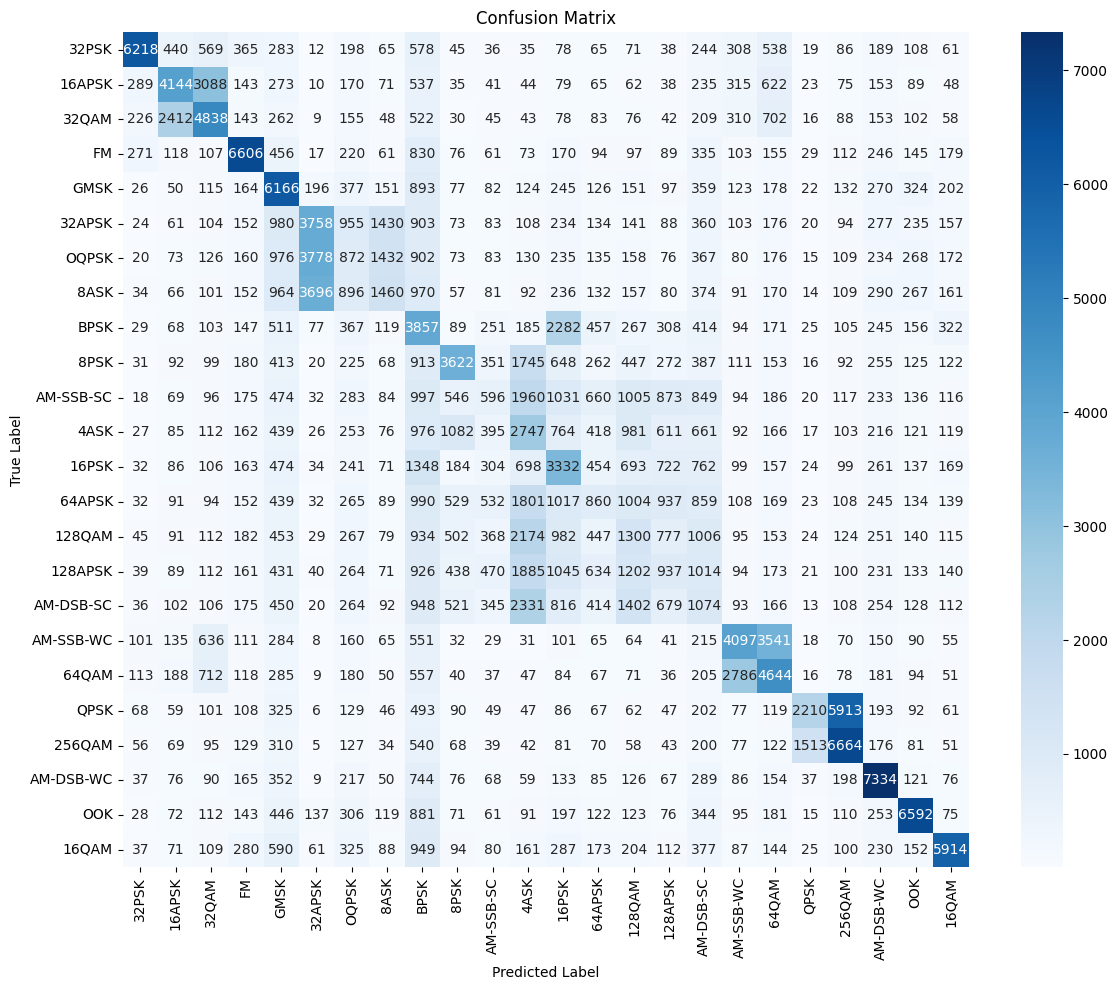


Classification Report:
               precision    recall  f1-score   support

       32PSK     0.7934    0.5839    0.6727     10649
      16APSK     0.4705    0.3891    0.4260     10649
       32QAM     0.4085    0.4543    0.4302     10650
          FM     0.6330    0.6203    0.6266     10650
        GMSK     0.3619    0.5790    0.4454     10650
      32APSK     0.3126    0.3529    0.3315     10650
       OQPSK     0.1130    0.0819    0.0950     10650
        8ASK     0.2467    0.1371    0.1762     10650
        BPSK     0.1696    0.3622    0.2310     10649
        8PSK     0.4286    0.3401    0.3793     10649
   AM-SSB-SC     0.1328    0.0560    0.0787     10650
        4ASK     0.1650    0.2580    0.2012     10649
       16PSK     0.2340    0.3129    0.2677     10650
      64APSK     0.1412    0.0808    0.1028     10649
      128QAM     0.1310    0.1221    0.1264     10650
     128APSK     0.1322    0.0880    0.1057     10650
   AM-DSB-SC     0.0947    0.1009    0.0977     10649
  

In [6]:

# Setup
MODEL_PATH = "/content/drive/MyDrive/RF Signal Classification/vtcnn2_ckpt.keras"
DATA_ROOT = "/content/drive/MyDrive/RF Signal Classification"
BATCH_SIZE = 256

# Load model
model = tf.keras.models.load_model(MODEL_PATH)
print("Loaded model from:", MODEL_PATH)

# Test Dataset Generator
class TestGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_path, y_path, batch_size):
        self.X = np.load(x_path, mmap_mode='r')
        self.y = np.load(y_path, mmap_mode='r')
        self.bs = batch_size
        self.idx = np.arange(len(self.y))
    def __len__(self): return int(np.ceil(len(self.idx)/self.bs))
    def __getitem__(self, i):
        sl = self.idx[i*self.bs:(i+1)*self.bs]
        xb = self.X[sl].transpose(0, 2, 1)  # (batch, 2, 1024) → (batch, 1024, 2)
        mu = xb.mean((1,2), keepdims=True)
        sd = xb.std((1,2), keepdims=True) + 1e-8
        xb = ((xb - mu) / sd)[..., None]  # (batch, 1024, 2, 1)
        return xb, self.y[sl]

test_gen = TestGenerator(f"{DATA_ROOT}/test_X.npy",
                         f"{DATA_ROOT}/test_y.npy",
                         batch_size=BATCH_SIZE)

# Model evaluation
loss, acc = model.evaluate(test_gen, verbose=1)
print(f"\nFINAL TEST ACCURACY: {acc:.4f} | LOSS: {loss:.4f}")

# Model prediction
y_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(np.load(f"{DATA_ROOT}/test_y.npy", mmap_mode='r'), axis=1)

# Building the confusion matrix

labels = np.load(os.path.join(DATA_ROOT, "classes.npy")).tolist()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=labels, digits=4)
print("\nClassification Report:\n", report)
